## Investigation of Weapon Use

In [4]:
import pandas as pd
import datetime
import numpy as np
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.pyplot import Normalize
%matplotlib inline

In [5]:
dir = '/Users/JoshLevin/PycharmProjects/data-visualizations/pubg/'

raw = pd.read_csv(filepath_or_buffer=dir+'source/pubg-match-deaths/deaths/kill_match_stats_final_0.csv')

In [20]:
bg = plt.imread(dir+'source/pubg-match-deaths/erangel.jpg')

def plotHist(x, y, sig, bins, alpha, color, alpha_scale):
    heatmap, xedges, yedges = np.histogram2d(x=x, y=y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=sig)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


    alphas = np.clip(Normalize(0, heatmap.max(), clip=True)(heatmap)*alpha_scale, 0.0, 1.0)
    colors = Normalize(0, heatmap.max(), clip=True)(heatmap)
    if color == 'RED':
        colors = cm.Reds(colors)
    elif color == 'ORANGE':
        colors = cm.Oranges(colors)
    elif color == 'BLUE':
        colors = cm.Blues(colors)
    elif color == 'GREEN':
        colors = cm.Greens(colors)
    elif color == 'YlGn':
        colors = cm.YlGn(colors)
    colors[..., -1] = alphas

    fig, ax = plt.subplots(figsize=(24,24))
    ax.set_xlim(0, 4096); ax.set_ylim(0, 4096)
    ax.imshow(bg)
    if color == 'RED':
        res = ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Reds, alpha=alpha)
    elif color == 'ORANGE':
        res = ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Oranges, alpha=alpha)
    elif color == 'BLUE':
        res = ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Blues, alpha=alpha)
    elif color == 'GREEN':
        res = ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Greens, alpha=alpha)
    elif color == 'YlGn':
        res = ax.imshow(colors, extent=extent, origin='lower', cmap=cm.YlGn, alpha=alpha)
    ax.invert_yaxis()
    plt.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

In [7]:
dir = '/Users/JoshLevin/PycharmProjects/data-visualizations/pubg/'

raw = pd.read_csv(filepath_or_buffer=dir+'source/pubg-match-deaths/deaths/kill_match_stats_final_0.csv')

In [8]:
baked = raw[raw['map'] == 'ERANGEL']
baked = baked[['time','killed_by']]

In [9]:
weapon_groups = {
    'AR' : ['SCAR-L', 'M416', 'M16A4', 'AKM', 'Groza', 'AUG', 'QBZ'],
    'LMG' : ['DP-28', 'M249'],
    'SMG' : ['Vector', 'UMP9', 'Tommy Gun', 'Micro UZI'],
    'DMR' : ['VSS', 'SKS', 'Mini 14', 'Mk14'],
    'Sniper' : ['AWM', 'M24', 'Kar98k', 'Win94'],
    'Pistol' : ['R1895', 'R45', 'P1911', 'P92', 'P18C'],
    'Shotgun' : ['S686', 'S1897', 'S12k'],
    'Car' : ['Dacia', 'Buggy', 'Hit by Car', 'Motorbike', 'Motorbike (SideCar)', 'Uaz'],
    'Boat' : ['Boat', 'Aquarail'],
    'Melee' : ['Crossbow', 'Crowbar', 'Machete', 'Punch', 'Pan', 'Sickle'],
    'Enviornment' : ['Bluezone', 'Down and Out', 'Falling', 'Drown'],
}
lookup = {}
for key, val in weapon_groups.items():
    for obj in val:
        lookup[obj] = key

def bucket_func(item):
    if item in lookup:
        return lookup[item]
    else:
        return 'Other'

In [10]:
baked['killed_by'] = baked['killed_by'].apply(bucket_func)

In [11]:
grouped = baked.groupby(['time', 'killed_by'], as_index=False)
df = grouped.agg(np.size)
df = df.unstack()
percent = df.div(df.sum(1)/100,0)

In [12]:
# Sort so that largest value is first
percent = percent.reindex(percent.sum().sort_values(ascending=True).index, axis=1)

## Weapon Distribution Over Time
Let's examine how different weapon categories shift as the game progresses.
See the following chart:

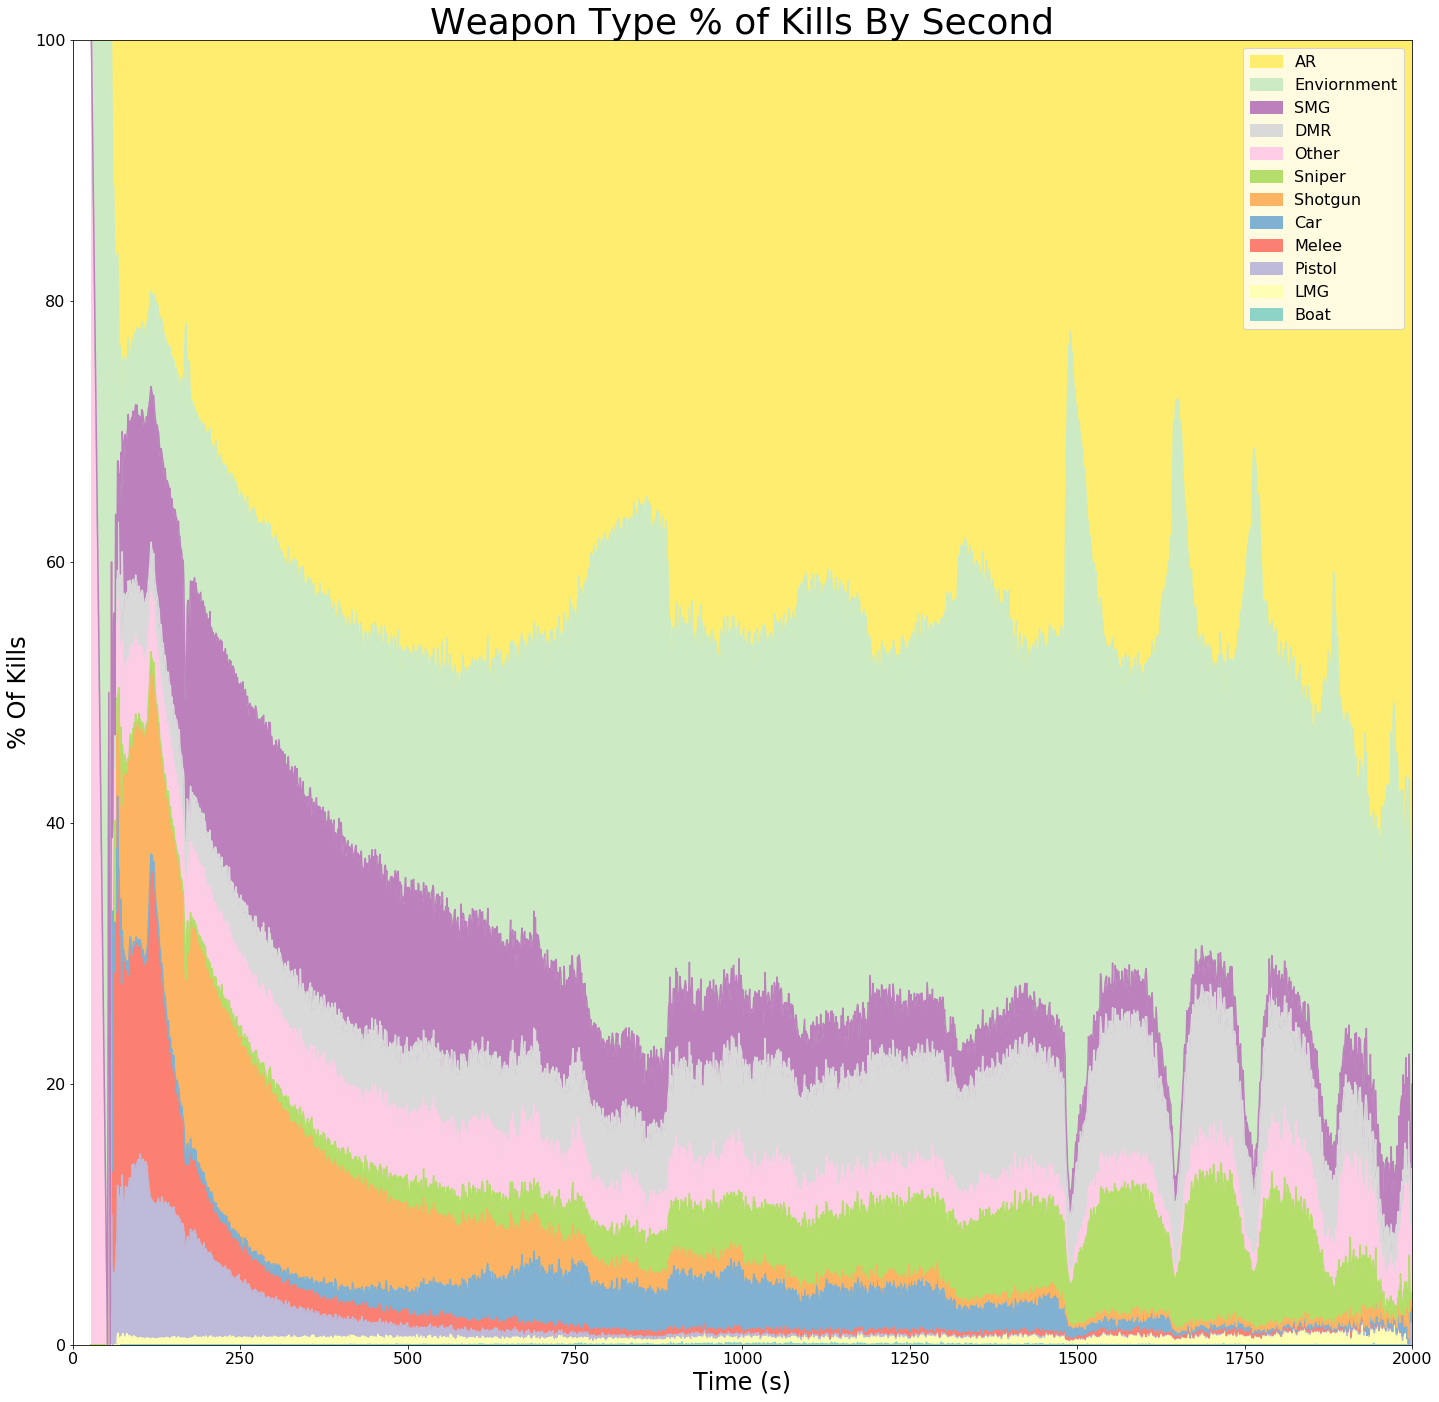

In [13]:
fig, ax = plt.subplots(figsize=(24,24))
ax.set_xlim(0,2000)
ax.set_ylim(0,100)

percent.plot.area(ax=ax, stacked=True, colormap=cm.Set3, use_index=True)


ax.set_xlabel('Time (s)', fontsize=24)
ax.set_title('Weapon Type % of Kills By Second', fontsize=36)
ax.set_ylabel('% Of Kills', fontsize=24)
ax.tick_params(axis='both', labelsize=16)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles=reversed(handles), labels=reversed(labels), loc='upper right', prop={'size': 16})
l.set_title('')

plt.savefig('weapon_type.png', bbox_inches='tight')

In [14]:
rarity = {
    'Crate' : ['AWM', 'M24', 'MK14', 'M249', 'Groza', 'AUG'],
    'Spawn' : ['SCAR-L', 'M416', 'M16A4', 'AKM', 'QBZ', 'DP-28',
              'Vector', 'UMP9', 'Tommy Gun', 'Micro UZI',
              'VSS', 'SKS', 'Mini 14', 'Kar98k', 'Win94',
              'R1895', 'R45', 'P1911', 'P92', 'P18C',
              'S686', 'S1897', 'S12k',
              'Crossbow', 'Crowbar', 'Machete', 'Punch', 'Pan', 'Sickle'],
}
rarity_look = {}
for key, val in rarity.items():
    for obj in val:
        rarity_look[obj] = key
                
def rarity_func(item):
    if item in rarity_look:
        return rarity_look[item]
    else:
        return 'Non-Weapon'

In [15]:
scale = lambda x : x * 4096 / 800000

cook = raw[raw['map'] == 'ERANGEL']
cook = cook[['time', 'killed_by', 'killer_position_x', 'killer_position_y']]
cook['killed_by'] = cook['killed_by'].apply(rarity_func)

In [16]:
rar_area = cook[['time', 'killed_by']]
rar_area = rar_area[rar_area['killed_by'] != 'Non-Weapon']
rar_grouped = rar_area.groupby(['time', 'killed_by'], as_index=False)
df_rar = rar_grouped.agg(np.size)
df_rar = df_rar.unstack()
percent_rar = df_rar.div(df_rar.sum(1)/100,0)

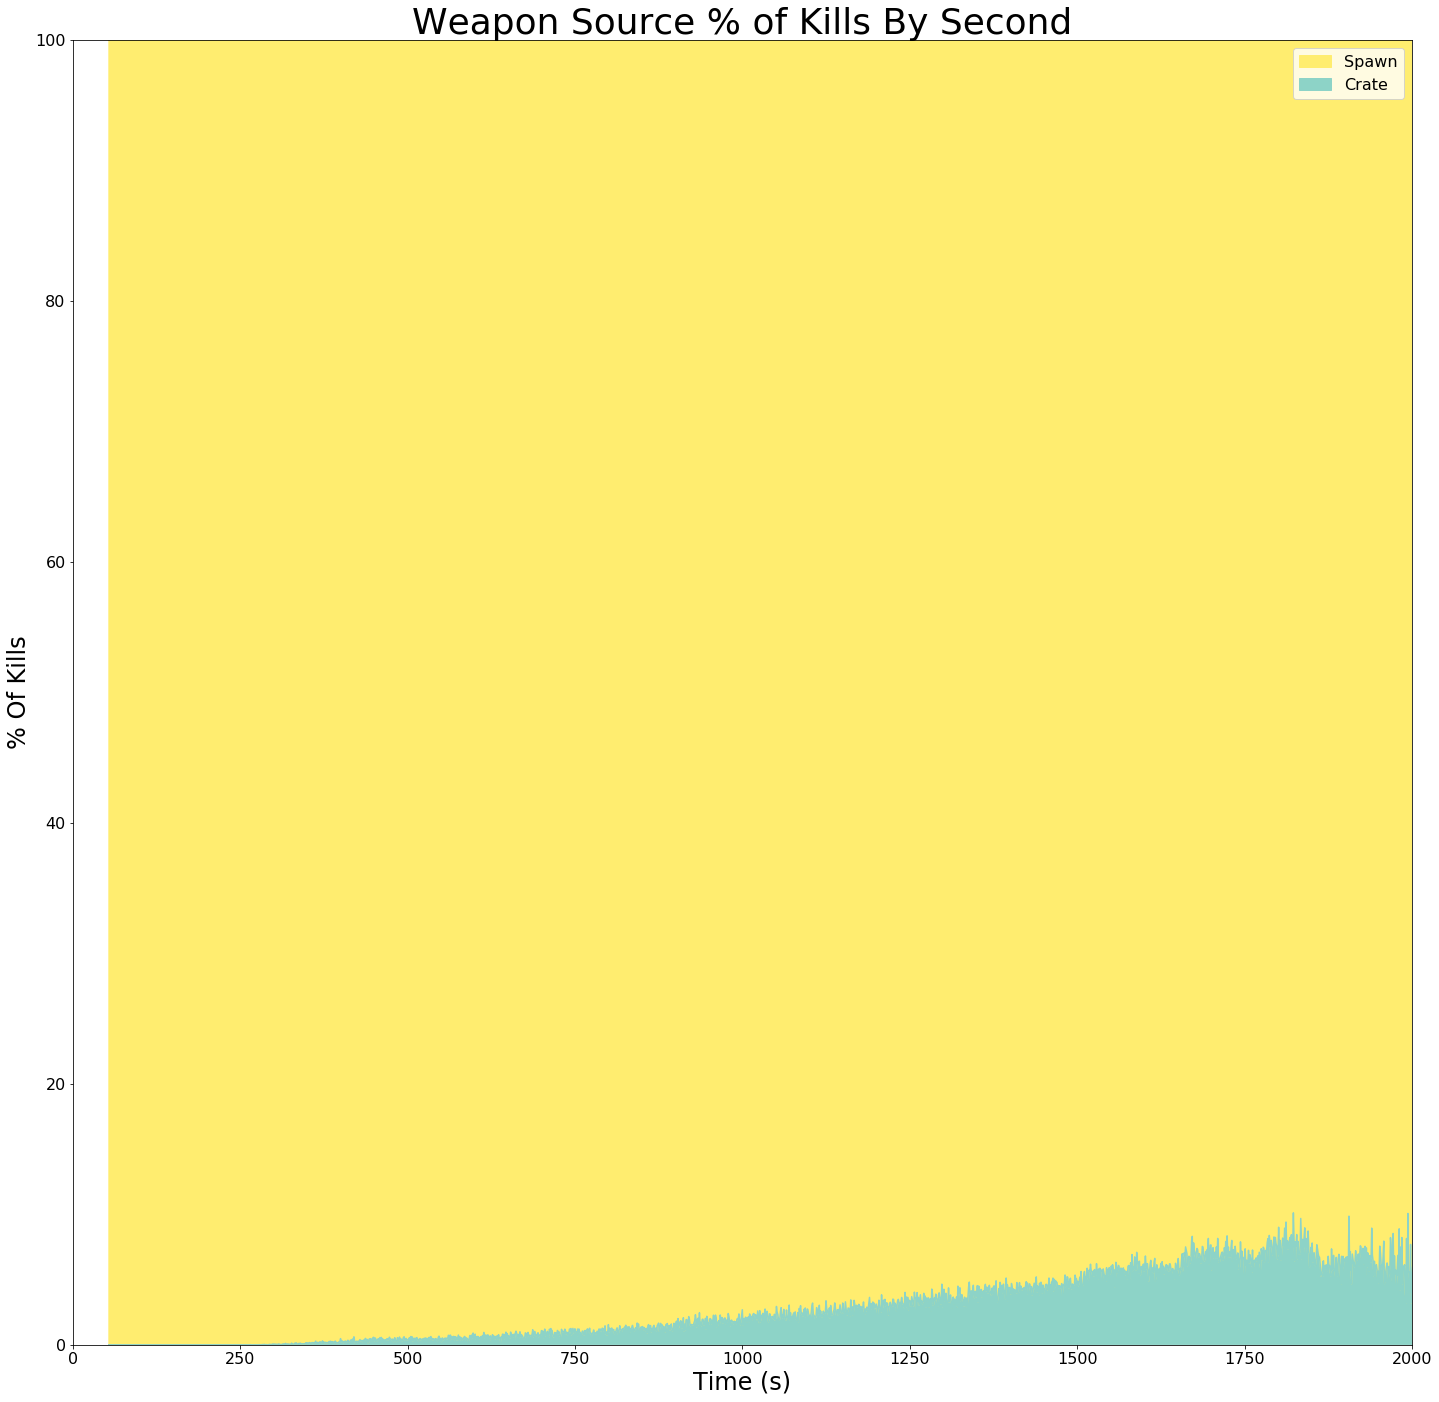

In [17]:
fig, ax = plt.subplots(figsize=(24,24))
ax.set_xlim(0,2000)
ax.set_ylim(0,100)

percent_rar.plot.area(ax=ax, stacked=True, colormap=cm.Set3)

ax.set_xlabel('Time (s)', fontsize=24)
ax.set_title('Weapon Source % of Kills By Second', fontsize=36)
ax.set_ylabel('% Of Kills', fontsize=24)
ax.tick_params(axis='both', labelsize=16)

handles, labels = ax.get_legend_handles_labels()

l = plt.legend(handles=reversed(handles), labels=reversed(labels), loc='upper right', prop={'size': 16})
l.set_title('')

plt.savefig('weapon_source.png', bbox_inches='tight')

In [18]:
# Crate only weapons
rar_pl = cook[cook['killed_by'] == 'Crate'].copy()

rar_pl = rar_pl[['killer_position_x', 'killer_position_y']].apply(scale)

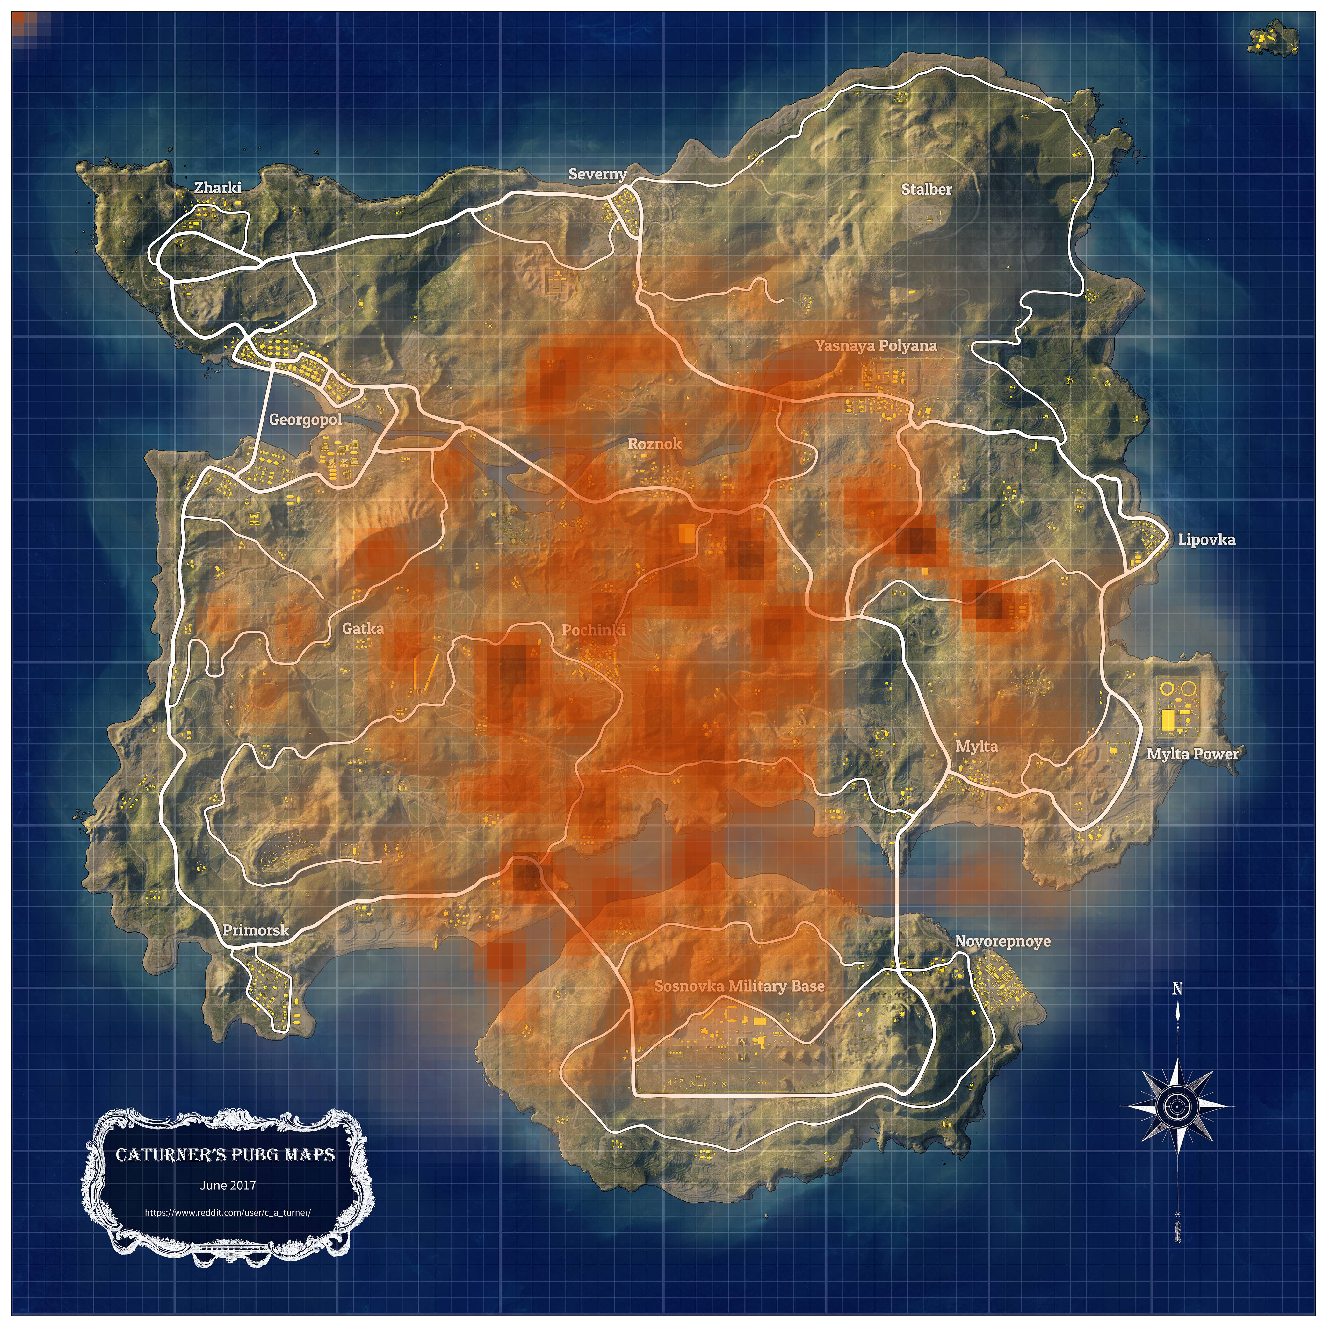

In [21]:
plotHist(x=rar_pl['killer_position_x'], y=rar_pl['killer_position_y'], sig=1.5, bins=100,
        alpha=0.8, color='ORANGE', alpha_scale=1.3)

plt.savefig('crate_kills.png', bbox_inches='tight')